In [7]:
import pyaudio
import wave
import datetime
import time
import sys
import numpy as np
import utility
import pickle

st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

p = pyaudio.PyAudio()
info = p.get_host_api_info_by_index(0);
numdevices = info.get('deviceCount')
for i in range(0, numdevices):
        dev = p.get_device_info_by_host_api_device_index(0, i);
        if (dev.get('maxInputChannels')) > 0:
            print (
                "Input Device id "+ str(i)+ " - "+ dev.get('name')+ 
                ", Channels count: "+ str(dev.get('maxInputChannels')) +
                ", Default sample rate: " + str(dev.get('defaultSampleRate'))
            )

try:
    input = raw_input
except NameError:
    pass

device = p.get_device_info_by_host_api_device_index(0, int(input("Chose device: ")));

CHUNK = 1024;
FORMAT = pyaudio.paInt16;
CHANNELS = int(device.get('maxInputChannels'));
RATE = int(device.get('defaultSampleRate'));
RATE = 192000;
INPUT_DEVICE_INDEX = int(device.get('index'));
RECORD_SECONDS = 3
WAVE_OUTPUT_FILENAME = st+".wav"

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input_device_index = INPUT_DEVICE_INDEX,
                input=True,
                frames_per_buffer=CHUNK)

print("start recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print(len(frames));
print("stop recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

with wave.open(WAVE_OUTPUT_FILENAME) as w:
    framerate = w.getframerate()
    frames = w.getnframes()
    channels = w.getnchannels()
    width = w.getsampwidth()
    print('sampling rate:', framerate, 'Hz')
    print('length:', frames, 'samples')
    print('channels:', channels)
    print('sample width:', width, 'bytes')
    
    data = w.readframes(frames)
    
    print(len(data))

Input Device id 0 - Built-in Microphone, Channels count: 2, Default sample rate: 44100.0
Input Device id 2 - UMC404HD 192k, Channels count: 4, Default sample rate: 48000.0
Input Device id 3 - UMC404HD 192k, Channels count: 4, Default sample rate: 48000.0
Chose device: 3
start recording
562
stop recording
sampling rate: 192000 Hz
length: 575488 samples
channels: 4
sample width: 2 bytes
4603904


In [8]:
sig = np.frombuffer(data, dtype='<i2').reshape(-1, channels)

with open('sig2.pickle', 'wb') as f:
    pickle.dump(sig, f)

normalized = utility.pcm2float(sig, np.float32)

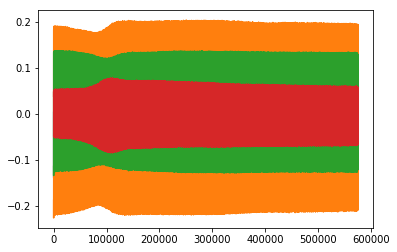

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.plot(normalized)

In [35]:
normalized.shape

(575488, 4)

In [36]:
import ipywidgets as widgets
from ipywidgets import interact

slider = widgets.FloatRangeSlider(value=[0,3.0],min=0.01,max=3.0,step=0.001,continuous_update=False)

def calculate_intervals(time):
    x = (1*time/RECORD_SECONDS)
    return int(frames*x)

def plot_graph(time):
    interval1 = calculate_intervals(time[0])
    interval2 = calculate_intervals(time[1])
    res = []
    for i in sig.T:
        res.append(i[interval1:interval2])
    
    plt.plot(np.array(res).T)


interact(plot_graph,time=slider);



interactive(children=(FloatRangeSlider(value=(0.01, 3.0), continuous_update=False, description='time', max=3.0, min=0.01, step=0.001), Output()), _dom_classes=('widget-interact',))

17.8 s ± 656 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


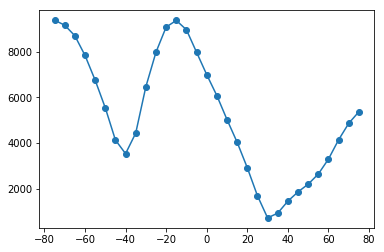

In [135]:
from scipy.ndimage.interpolation import shift

angles = np.array([-75, -70, -65, -60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75])
offsets = np.array([
    [-164, -82, 82, 164],
    [-160, -80, 80, 160],
    [-154, -77, 77, 154],
    [-146, -73, 73, 146],
    [-138, -69, 69, 138],
    [-130, -65, 65, 130],
    [-120, -60, 60, 120],
    [-108, -54, 54, 108],
    [-98, -49, 49, 98],
    [-84, -42, 42, 84],
    [-72, -36, 36, 72],
    [-58, -29, 29, 58],
    [-44, -22, 22, 44],
    [-30, -15, 15, 30],
    [-14, -7, 7, 14],
    [0, 0, 0, 0],
    [14, 7, -7, -14],
    [30, 15, -15, -30],
    [44, 22, -22, -44],
    [58, 29, -29, -58],
    [72, 36, -36, -72],
    [84, 42, -42, -84],
    [98, 49, -49, -98],
    [108, 54, -54, -108],
    [120, 60, -60, -120],
    [130, 65, -65, -130],
    [138, 69, -69, -138],
    [146, 73, -73, -146],
    [154, 77, -77, -154],
    [160, 80, -80, -160],
    [164, 82, -82, -164]
]);

directions = np.array([np.sum(np.array([shift(channel,bias,cval=0) for (channel,bias) in zip(sig.T, offset)]).T, axis=1) for offset in offsets])

rms = np.array([np.sqrt(np.mean(direction**2)) for direction in directions])
plt.plot(angles, rms, marker='o')

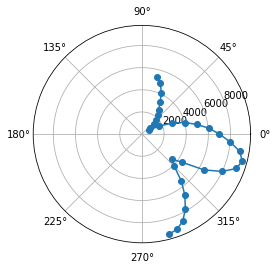

In [106]:
theta = [angle/180.0*np.pi for angle in angles]
ax = plt.subplot(111, projection='polar')
ax.plot(theta, rms, marker='o')

Text(-5,9410,'max')

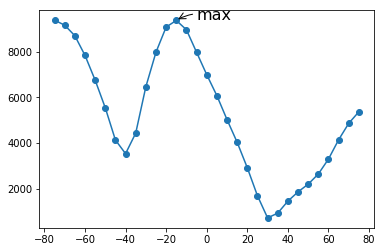

In [110]:
xmax,ymax = -15,9380

plt.plot(angles, rms, marker='o')
plt.annotate('max',
             xy=(xmax, ymax),
             xytext=(xmax+10, ymax+30), fontsize=16, xycoords='data',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))



In [11]:
from scipy import signal
import numpy as np

a = np.array([1,2,5,6]).T
b = np.array([3,2,5,7]).T

c = signal.correlate(a,b,method='direct',mode='full')
print(c)

[ 7 19 47 74 46 27 18]


In [1]:
rms.argmax()

NameError: name 'rms' is not defined